In [17]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy import constants as cons
from astropy.coordinates import SkyCoord, Distance, Angle
from astropy.io import fits
from astroquery.vizier import Vizier
from astropy.cosmology import Planck18 as cosmo
from astropy.table import Table

In [ ]:
#Add the following QSO catalogues
#1 - KODIAQ - J/AJ/154/114 - DONE
#2 - Milliquas - VII/290 - DONE
#3 - SDSS DR16
#4 - SQUAD - https://github.com/MTMurphy77/UVES_SQUAD_DR1/tree/master - DONE
#5 - Hubble sample/query
#6 - SALT archive?

# Function to generate qso coordinates to query list file for hubble
# Function to sort nqso table by qso magnitude

# Ancillary multi-wavelength, multi-technique, "footprint"
#6 - MUSE/ESO
#7 - ALMA/VLA/NRAO
#8 - HIPASS/WALLABY/APERTIF

#Features (priority)
# Find missing parameters from Simbad/NED eg; z
# Read target catalogue from ASCII/FITS - user input
# For small catalogues retrieve images and plot qsos and circle showing x Mpc radius
# Get x from user

In [ ]:
def tarcolid(viztab):
    #get tar column names, itercol and get z col; check if it has _RA and _DE columns. If not extract skycoord objects and return them
    # Handle cz/velocity
    # Get keys from catalogue

In [ ]:
def dec_limits():
    # Function to return dec limits from input table

### Function to read target Vizier table and return Table object with 5Mpc radius column

In [27]:
def tar_read(viztab,redshift_str, namecol,rkpc=5000):
    target = Vizier(catalog=viztab, row_limit=-1, columns=['*', '_RAJ2000', '_DEJ2000',namecol]).query_constraints(z=">0")[0]
    if redshift_str =='cz' or redshift_str =='VHI':
        z_arr=np.array(target[redshift_str])/(cons.c.to('km/s').value)
    elif redshift_str=='z':
        z_arr=np.array(target[redshift_str])                                 #Account for other variations of colname

    full_target=target.copy()                                                       #Creates backup table
    scale_z=cosmo.kpc_proper_per_arcmin(z_arr)/60                                   #Calculate scale at z
    theta=Angle((rkpc/scale_z).value, u.arcsec)                                     #5 Mpc at target z in arcsec
    target.add_column(theta.arcminute*u.arcmin, name='5MPc-radius', index=4)
    search_r=round(np.max(theta.degree),2)
    print('Using the maximum angular radius at z =',np.min(z_arr),'for searching; r =',search_r,'deg')

    tar_coord = SkyCoord(target['_RAJ2000'], target['_DEJ2000'], frame='icrs')
    tar_dist = Distance(z=z_arr,cosmology=cosmo)


    return target, full_target, search_r, tar_coord, tar_dist

### Function to query KQCG

In [3]:
def kqcg_query(target, search_r=1*u.degree):
    kqcg_table="J/other/RAA/19.29"
    qso = Vizier(catalog=kqcg_table, column_filters={"z":">0.0"}, columns=['*','_q','_RAJ2000','_DEJ2000','z']).query_region(target, radius= search_r*u.degree)[0]
    # For cases without _RA and _DEC write loop that queries table for each tar sky coord object 
    return qso

### Function to query Milliquas

In [4]:
def milliquas_query(target, search_r=1*u.degree):
    kqcg_table="VII/290/catalog"
    qso = Vizier(catalog=kqcg_table, column_filters={"z":">0.0"}, columns=['*','_q','_RAJ2000','_DEJ2000','z']).query_region(target, radius= search_r*u.degree)[0]
    # For cases without _RA and _DEC write loop that queries table for each tar sky coord object 
    return qso

### Function to query KODIAQ

In [5]:
def kodiaq_query(target, search_r=1*u.degree):
    kodiaq_table="J/AJ/154/114/table3" #table2 ?
    qso = Vizier(catalog=kodiaq_table, column_filters={"zem":">0.0"}, columns=['*','_q','_RAJ2000','_DEJ2000','zem']).query_region(target, radius= search_r*u.degree)[0]
    # For cases without _RA and _DEC write loop that queries table for each tar sky coord object 
    qso.rename_columns(['zem','KODIAQ'],['z','Name'])
    return qso

### Function to Trim header comments

In [6]:
def header_trimmer(result,target,trimAll=False,num=38,tabnum=55):                  #See issue https://github.com/astropy/astropy/issues/9093
    #result.info()
    print()
    for icol, col in enumerate(result.itercols()):
        #print(icol,':', col.description,';', len(col.description))
        if len(col.description) >= 40:
            print('ALERT: Shortening Column Desctiption of col',icol,'from',len(col.description),'characters to',num)
            print('\nFull Description:')
            print(result.columns[icol].description)
            print('\nShort Description:')
            result.columns[icol].description = result.columns[icol].description[0:num]
            print(icol,':', col.description, ';', len(col.description))
            print('***********************************')

        if trimAll:
            print('ALERT: trimAll is True. This will erase all column descriptions')
            result.columns[icol].description = ''
    
    print('ALERT: Shortening Table Desctiption to',tabnum,'characters')
    print(result.meta['description'],' : ',len(result.meta['description']))
    result.meta['description']=target.meta['description'][0:tabnum]
    print(result.meta['description'],' : ',len(result.meta['description']))
    print('\n')
    #result.info()
    return result

### Function to combine qso table and target table

In [7]:
def table_comb(qso,target, tar_coord, tar_dist, namecol, redshift_str):

    full_qso=qso.copy(),False
    
    sepcol=[]*u.deg
    rm_index=[]
    tar_name=[]
    tar_ra=[]
    tar_dec=[]
    tar_z=[]
    tar_rad=[]*u.arcminute

    for index, probe in enumerate(qso):
        probe_coord=SkyCoord(probe['_RAJ2000']*u.deg, probe['_DEJ2000']*u.deg, frame='icrs')
        probe_dist=Distance(z=np.array(probe['z']),cosmology=cosmo)
        tar_ind=probe['_q']-1
        sep = probe_coord.separation(tar_coord[tar_ind])

        if probe_dist < tar_dist[tar_ind] or target['5MPc-radius'][tar_ind]*u.arcminute < sep.arcminute*u.arcminute:
            rm_index=np.append(rm_index,int(index))
        else:  #This checks for the QSO to be behind the cluster in z and for the projected seperation to be smaller than 5Mpc radius at cluster z
            sepcol=np.append(sepcol,sep)
            tar_name=np.append(tar_name,target[namecol][tar_ind]) #get_keys from target
            tar_ra=np.append(tar_ra,target['_RAJ2000'][tar_ind]) #get_keys from target
            tar_dec=np.append(tar_dec,target['_DEJ2000'][tar_ind]) #get_keys from target
            tar_z=np.append(tar_z,target[redshift_str][tar_ind]) #get_keys from target
            tar_rad=np.append(tar_rad,target['5MPc-radius'][tar_ind]*u.arcminute) #get_keys from target

    qso.remove_rows(rm_index.astype(int))

    qso.add_column(sepcol.arcminute,name='Separation',index=-1)

    tar_names=['Target','tar_RA','tar_DEC','tar_z','5MPc-radius']
    qso.add_columns([tar_name,tar_ra,tar_dec,tar_z,tar_rad],names=tar_names,indexes=[0,0,0,0,0])

    qso_names=['QSO','qso_RA','qso_DEC','qso_z']
    qso.rename_columns(['Name','_RAJ2000','_DEJ2000','z'],qso_names)

    oth_names=['Separation','_q']
    col_names=np.concatenate((tar_names,qso_names,oth_names))
    qso.keep_columns(col_names)
    #qso.pprint() 

    return qso, full_qso

### Function to plot mollweide projection of the combined table

In [8]:
def plot_combtab(qso,pltname):
    #Function to plot final Ra-Dec of combined table
    
    plt.figure(figsize=(16,9))
    plt.subplot(111, projection="mollweide")
    #plt.title("SPT + KQCG",fontsize='xx-large')
    plt.ylabel("Declination (deg)",fontsize='xx-large')
    plt.xlabel("Right Ascension (hr)",fontsize='xx-large')
    plt.grid(True)

    plt.margins(0.005)
    plt.xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]), labels=['10h', '8h', '6h', '4h', '2h', '0h','22h', '20h', '18h', '16h', '14h'])

    ntar_coord=SkyCoord(qso['tar_RA']*u.deg,qso['tar_DEC']*u.deg)
    qso_coord=SkyCoord(qso['qso_RA'],qso['qso_DEC'])

    plt.plot(ntar_coord.ra.wrap_at('180d').radian, ntar_coord.dec.radian, 'o', markersize=10, alpha=0.6, label='Target')
    plt.plot(qso_coord.ra.wrap_at('180d').radian, qso_coord.dec.radian, '+', markersize=10, alpha=1.0, label='QSO')

    plt.legend(fancybox=True, fontsize='x-large')

    plt.savefig(pltname, transparent=False, facecolor='w')

### Function to read SQUAD csv and return coordinate objects

In [9]:
def squad_read():
    # Incorporating Squad
    squadcsv='Squad_DR1_quasars_master.csv'
    squad=Table.read(squadcsv,format='ascii')
    squad_coord=SkyCoord(squad['RA_Adopt'], squad['Dec_Adopt'], frame='icrs',unit=(u.hourangle, u.deg))
    squad_dist=Distance(z=np.array(squad['zem_Adopt']),cosmology=cosmo)
    #print(squad_coord.to_string('hmsdms'))
    
    # squad['Name_Adopt']
    return squad, squad_coord, squad_dist #return col_names and/or rename columns

### Function to read COS csv and return table & coordinate objects

In [10]:
def hsla_cos_read():
    #Read HSLA
    hsla_cos = Table.read('799_HSLA_COSQ.lst', format='ascii', header_start=0)  
    hsla_coord=SkyCoord(hsla_cos['RA'], hsla_cos['DEC'], frame='icrs',unit=(u.deg, u.deg))
    hsla_dist=Distance(z=np.array(hsla_cos['zemi']),cosmology=cosmo)
    
    hsla_cos.rename_column('TargetName','Name_Adopt')
    return hsla_cos, hsla_coord, hsla_dist #return col_names and/or rename columns

### Function to do a simple linear search of qso tables where qso_z > tar_z && qso_tar_seperation < 5Mpc at tar_z

In [11]:
def linear_search(sample, sample_coord, sample_dist, target, tar_coord, tar_dist, redshift_str, namecol):
    #Add Trim target based on SQUAD dec constraints
    for i, tar in enumerate(target):
        for j, quas in enumerate(sample):
            sep = sample_coord[j].separation(tar_coord[i]).arcminute*u.arcminute
            if sep <= tar['5MPc-radius']*u.arcminute and sample_dist[j] > tar_dist[i]:
                print(tar[namecol],'\t',tar[redshift_str],'\t',quas['Name_Adopt'],'\t',sep) #Make general

# Running KQCG, milliquas Squad & COS search for SPT

Using the maximum angular radius at z = 0.045 for searching; r = 1.52 deg
J0425-3742 	 0.321 	 J042442-375620 	 16.646739961270512 arcmin
J0552-2103 	 0.099 	 J055158-211949 	 20.50233377865606 arcmin
J1246-2548 	 0.32 	 J124646-254749 	 9.05472279734354 arcmin
J0011-2841 	 0.089 	 J000852-290043 	 37.45437191132703 arcmin
J0011-2841 	 0.089 	 J000857-290126 	 36.90655880946131 arcmin
J0227-2852 	 0.214 	 J022620-285750 	 12.7655424296716 arcmin
J0302-3209 	 0.322 	 J030249-321600 	 6.492316861714049 arcmin
J0308-2947 	 0.9 	 J030844-295702 	 9.882229378449878 arcmin
J0350-3801 	 0.38 	 J034943-381030 	 13.999363533245795 arcmin
J2219-2809 	 0.18 	 J222006-280323 	 10.077449966793717 arcmin


  Target    tar_RA tar_DEC        tar_z           5MPc-radius      _q    qso_RA     qso_DEC        QSO       qso_z      Separation    
                                                     arcmin               deg         deg                                             
---------- ------- -------- ------------------ ------------------ --- ----------- ----------- -------------- ------ ------------------
J0350-3801 57.6594 -38.0256 0.3799999952316284 15.520218672112108 353  57.4320000 -38.1753056 J034943-381031  3.222 13.998664172053402


/home/spectram/miniconda3/envs/gen/lib/python3.9/site-packages/astropy/cosmology/flrw.py:1072: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(self._inv_efunc_scalar, z1, z2, args=self._inv_efunc_scalar_args)[0]
/home/spectram/miniconda3/envs/gen/lib/python3.9/site-packages/numpy/lib/function_base.py:2246: RuntimeWarning: invalid value encountered in _integral_comoving_distance_z1z2_scalar (vectorized)
  outputs = ufunc(*inputs)


J0302-3209 	 0.322 	 2QZJ0302-3216 	 6.499554439820416 arcmin


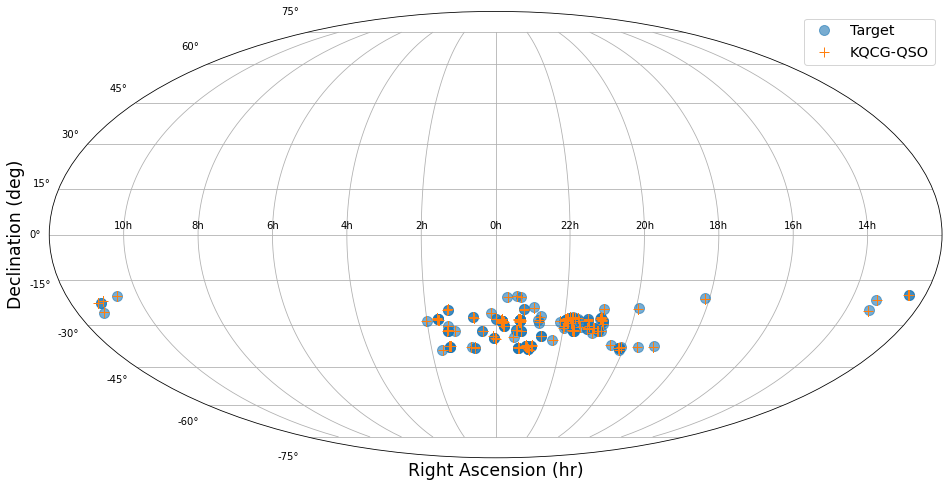

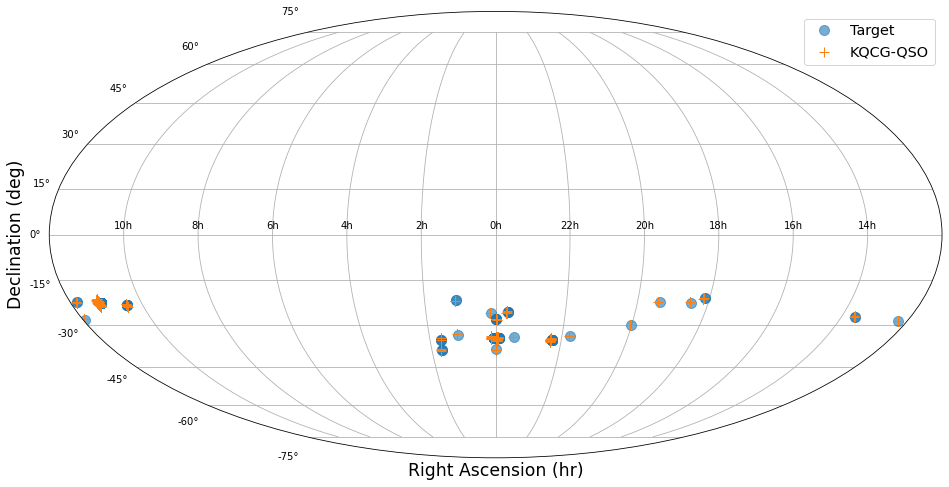

In [56]:
viztab="J/ApJS/247/25/cand" #SPT                #get from user
redshift_str='z'
namecol='SPT-CL'
target, full_target, search_r, tar_coord, tar_dist = tar_read(viztab,redshift_str,namecol)

qso = kqcg_query(target, search_r)
nqso, full_qso = table_comb(qso,target,tar_coord, tar_dist,namecol, redshift_str)

'''
outfile='trial.fits'                            #get from user
nqso.write(outfile,overwrite=True)
header_trimmer(full_qso,False)
header_trimmer(full_target,False)
full_target.write(outfile,append=True)
full_qso.write(outfile,append=True)
'''

pltname='SPT+KQCG.png'
plot_combtab(nqso,pltname)

qso = milliquas_query(target, search_r)
nqso, full_qso = table_comb(qso,target,tar_coord, tar_dist,namecol, redshift_str)

pltname='SPT+milliquas.png'
plot_combtab(nqso,pltname)

qso = kodiaq_query(target, search_r)
nqso, full_qso = table_comb(qso,target,tar_coord, tar_dist,namecol, redshift_str)
nqso.pprint_all()

squad, squad_coord, squad_dist = squad_read()
linear_search(squad, squad_coord, squad_dist, target, tar_coord, tar_dist, redshift_str, namecol)

hsla_cos, hsla_coord, hsla_dist = hsla_cos_read()
linear_search(hsla_cos, hsla_coord, hsla_dist, target, tar_coord, tar_dist, redshift_str, namecol)


# Running KQCG, milliquas Squad & COS search for RedMapper SVA1

Using the maximum angular radius at z = 0.2014 for searching; r = 0.41 deg


       Target           tar_RA    tar_DEC         tar_z           5MPc-radius      _q    qso_RA     qso_DEC        QSO       qso_z      Separation    
                                                                     arcmin               deg         deg                                             
-------------------- ----------- --------- ------------------- ------------------ --- ----------- ----------- -------------- ------ ------------------
RMJ024412.0-013440.9 41.04981389 -1.578035 0.25450000166893005 20.374119924900178 985  41.0076667  -1.5676944 J024401-013403  4.010 2.6029043484965797
RMJ224857.1-443010.7 	 0.3718 	 J224931-441730 	 14.120396585371944 arcmin
RMJ041859.1-571227.8 	 0.4322 	 J041950-571612 	 7.9492404751067784 arcmin
RMJ041859.7-572425.2 	 0.4828 	 J041950-571612 	 10.727838792508724 arcmin
RMJ024412.0-013440.9 	 0.2545 	 J024401-013403 	 2.602113096110733 arcmin
RMJ033055.9-270915.1 	 0.7795 	 J033032-270438 	 6.935807832152338 arcmin


/home/spectram/miniconda3/envs/gen/lib/python3.9/site-packages/astropy/cosmology/flrw.py:1072: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(self._inv_efunc_scalar, z1, z2, args=self._inv_efunc_scalar_args)[0]
/home/spectram/miniconda3/envs/gen/lib/python3.9/site-packages/numpy/lib/function_base.py:2246: RuntimeWarning: invalid value encountered in _integral_comoving_distance_z1z2_scalar (vectorized)
  outputs = ufunc(*inputs)


RMJ043817.9-531039.7 	 0.293 	 HE0435-5304 	 17.643075321447512 arcmin
RMJ043703.6-530559.9 	 0.2863 	 HE0435-5304 	 7.434565981674816 arcmin
RMJ044054.5-525603.5 	 0.7589 	 HE0439-5254 	 10.07706692499956 arcmin


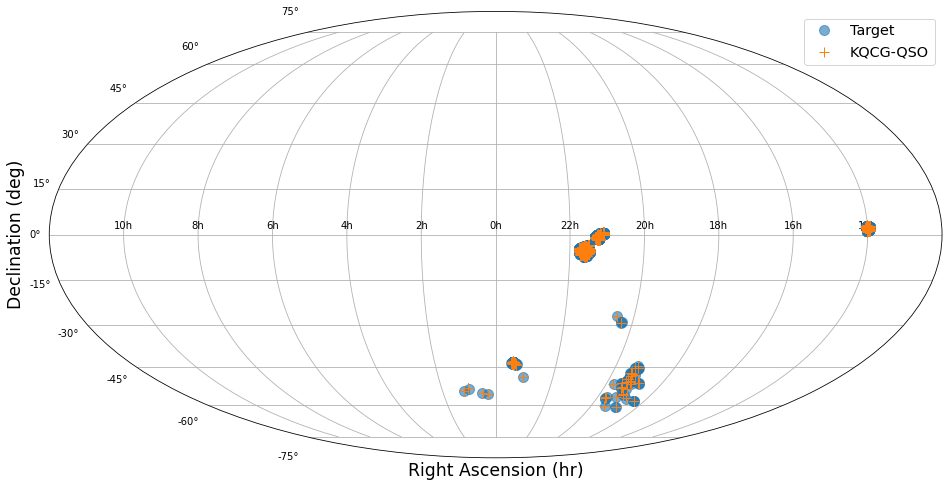

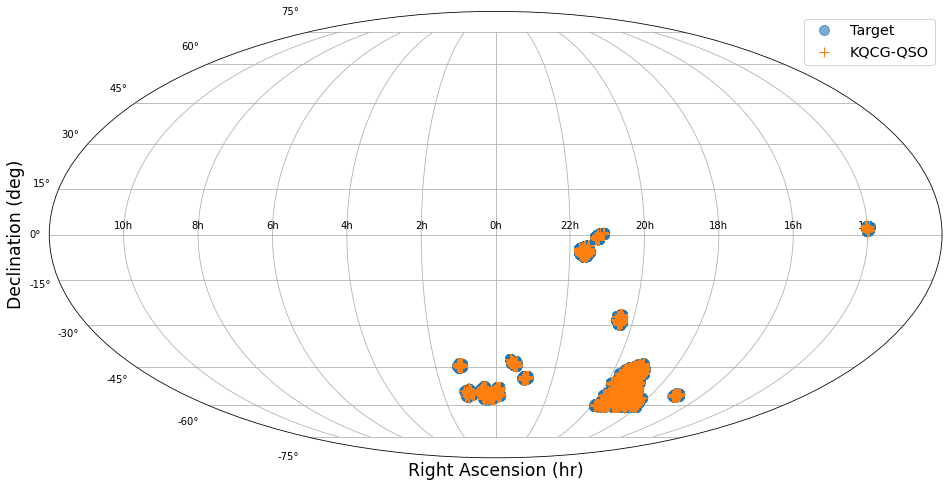

In [57]:
viztab="J/ApJS/224/1/sva1exp" #redMaPPer SVA1 expanded from DES               #get from user
redshift_str='zlambda'
namecol='Name'
target, full_target, search_r, tar_coord, tar_dist = tar_read(viztab, redshift_str, namecol)

qso = kqcg_query(target, search_r)
nqso, full_qso = table_comb(qso,target,tar_coord, tar_dist,namecol,redshift_str)

pltname='redmapper+kqcg.png'
plot_combtab(nqso,pltname)

qso = milliquas_query(target, search_r)
nqso, full_qso = table_comb(qso,target,tar_coord, tar_dist,namecol,redshift_str)

pltname='redmapper+milliquas.png'
plot_combtab(nqso,pltname)

qso = kodiaq_query(target, search_r)
nqso, full_qso = table_comb(qso,target,tar_coord, tar_dist,namecol,redshift_str)
nqso.pprint_all()

squad, squad_coord, squad_dist = squad_read()
linear_search(squad, squad_coord, squad_dist, target, tar_coord, tar_dist, redshift_str, namecol)

hsla_cos, hsla_coord, hsla_dist = hsla_cos_read()
linear_search(hsla_cos, hsla_coord, hsla_dist, target, tar_coord, tar_dist, redshift_str, namecol)

# CRG

In [25]:
viztab="J/ApJS/181/572/table12" #Madore+2009               #get from user
redshift_str='cz'
namecol='Host'
target, full_target, search_r, tar_coord, tar_dist = tar_read(viztab,redshift_str,namecol)

# qso = kqcg_query(target, search_r)
# nqso, full_qso = table_comb(qso,target,tar_coord, tar_dist,namecol, redshift_str)

# pltname='SPT+KQCG.png'
# plot_combtab(nqso,pltname)

qso = milliquas_query(target, search_r)
nqso, full_qso = table_comb(qso,target,tar_coord, tar_dist,namecol, redshift_str)

# pltname='SPT+milliquas.png'
# plot_combtab(nqso,pltname)

# qso = kodiaq_query(target, search_r)
# nqso, full_qso = table_comb(qso,target,tar_coord, tar_dist,namecol, redshift_str)
# nqso.pprint_all()

squad, squad_coord, squad_dist = squad_read()
linear_search(squad, squad_coord, squad_dist, target, tar_coord, tar_dist, redshift_str, namecol)

hsla_cos, hsla_coord, hsla_dist = hsla_cos_read()
linear_search(hsla_cos, hsla_coord, hsla_dist, target, tar_coord, tar_dist, redshift_str, namecol)


/home/spectram/miniconda3/envs/workenv/lib/python3.9/site-packages/astropy/cosmology/flrw.py:1072: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(self._inv_efunc_scalar, z1, z2, args=self._inv_efunc_scalar_args)[0]
/home/spectram/miniconda3/envs/workenv/lib/python3.9/site-packages/numpy/lib/function_base.py:2387: RuntimeWarning: invalid value encountered in _integral_comoving_distance_z1z2_scalar (vectorized)
  outputs = ufunc(*inputs)


Using the maximum angular radius at z = -7163.234399979468 for searching; r = nan deg
AM 0034-351 	 8891 	 J004216-333754 	 100.80298768327434 arcmin
AM 0035-335 	 9050 	 J004216-333754 	 57.510329505270285 arcmin
AM 0035-335 	 9104 	 J004216-333754 	 56.71352291443461 arcmin
AM 0035-335 	 8639 	 J004216-333754 	 57.0313862481376 arcmin
AM 0126-525 	 3700 	 J012550-535225 	 77.7612481377013 arcmin
AM 0126-525 	 3450 	 J012550-535225 	 77.74003710750654 arcmin
AM 0322-374 	 1405 	 J021741-370059 	 789.995878397853 arcmin
AM 0322-374 	 1405 	 J022928-364357 	 652.1761345262968 arcmin
AM 0322-374 	 1405 	 J024449-290449 	 703.456501185304 arcmin
AM 0322-374 	 1405 	 J025634-401300 	 358.13857055674686 arcmin
AM 0322-374 	 1405 	 J030211-314030 	 440.84309414661226 arcmin
AM 0322-374 	 1405 	 J030249-321600 	 407.57904181529716 arcmin
AM 0322-374 	 1405 	 J030640-301031 	 489.4692878397302 arcmin
AM 0322-374 	 1405 	 J030643-301107 	 488.66471099767114 arcmin
AM 0322-374 	 1405 	 J030722-4

/home/spectram/miniconda3/envs/workenv/lib/python3.9/site-packages/astropy/cosmology/flrw.py:1072: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(self._inv_efunc_scalar, z1, z2, args=self._inv_efunc_scalar_args)[0]
/home/spectram/miniconda3/envs/workenv/lib/python3.9/site-packages/numpy/lib/function_base.py:2387: RuntimeWarning: invalid value encountered in _integral_comoving_distance_z1z2_scalar (vectorized)
  outputs = ufunc(*inputs)


AM 0053-353 	 14494 	 HE0056-3622 	 58.37770229334544 arcmin
AM 0053-353 	 14420 	 HE0056-3622 	 58.41250310535837 arcmin
AM 0126-525 	 3700 	 RBS144 	 271.81325690765453 arcmin
AM 0126-525 	 3450 	 RBS144 	 271.91423749849804 arcmin
AM 0322-374 	 1405 	 2DFGRSS393Z082 	 656.1200293308142 arcmin
AM 0322-374 	 1405 	 2QZJ0302-3216 	 407.57586968693505 arcmin
AM 0322-374 	 1405 	 CTS0216 	 799.4305100426766 arcmin
AM 0322-374 	 1405 	 HE0226-4110 	 677.9975610430489 arcmin
AM 0322-374 	 1405 	 HE0241-3043 	 652.8046079753889 arcmin
AM 0322-374 	 1405 	 HE0248-3628 	 402.45338277356007 arcmin
AM 0322-374 	 1405 	 Q0244-303 	 639.4125613615964 arcmin
AM 0322-374 	 1405 	 Q0246-308 	 603.7362190602813 arcmin
AM 0322-374 	 1405 	 HE0331-4112 	 236.89647830787635 arcmin
AM 0322-374 	 1397 	 2DFGRSS393Z082 	 656.0995912322578 arcmin
AM 0322-374 	 1397 	 2QZJ0302-3216 	 407.597038550563 arcmin
AM 0322-374 	 1397 	 CTS0216 	 799.2173542817101 arcmin
AM 0322-374 	 1397 	 HE0226-4110 	 677.7633078

In [ ]:
from astroquery.ipac.ned import Ned
result_table = Ned.query_object("Arp 271")
print(result_table)

# https://astroquery.readthedocs.io/en/latest/ipac/ned/ned.html

In [ ]:
#SQUAD and CRG
#Trim target based on SQUAD dec constraints

target = Vizier(catalog="J/ApJS/181/572/table12", row_limit=-1, columns=['*', '_RAJ2000', '_DEJ2000','Full',]).query_constraints(Full=">0")[0]
qso = Vizier(catalog="J/other/RAA/19.29", column_filters={"z":">0.0"}, columns=['*','_q','RAJ2000','DEJ2000','z']).query_region(target, radius=1*u.degree)[0]

for i, tar in enumerate(target):
    for j, quas in enumerate(squad):
        sep = squad_coord[j].separation(tar_coord[i]).degree*u.degree
        if sep <= 1*u.degree:
            print(tar['Host'],'\t',quas['Name_Adopt'],'\t',sep.to('arcminute'))

# Choirs

In [31]:
viztab="J/MNRAS/433/543/table1"              #get from user
redshift_str='VHI'
namecol='HIPASS'
target, full_target, search_r, tar_coord, tar_dist = tar_read(viztab,redshift_str,namecol)

# qso = kqcg_query(target, search_r)
# nqso, full_qso = table_comb(qso,target,tar_coord, tar_dist,namecol, redshift_str)

# pltname='SPT+KQCG.png'
# plot_combtab(nqso,pltname)

qso = milliquas_query(target, search_r)
nqso, full_qso = table_comb(qso,target,tar_coord, tar_dist,namecol, redshift_str)

# pltname='SPT+milliquas.png'
# plot_combtab(nqso,pltname)

# qso = kodiaq_query(target, search_r)
# nqso, full_qso = table_comb(qso,target,tar_coord, tar_dist,namecol, redshift_str)
# nqso.pprint_all()

squad, squad_coord, squad_dist = squad_read()
linear_search(squad, squad_coord, squad_dist, target, tar_coord, tar_dist, redshift_str, namecol)

hsla_cos, hsla_coord, hsla_dist = hsla_cos_read()
linear_search(hsla_cos, hsla_coord, hsla_dist, target, tar_coord, tar_dist, redshift_str, namecol)


Using the maximum angular radius at z = 0.005253634499370895 for searching; r = 12.39 deg


J0209-10 	 3900 	 J015741-104340 	 180.2632868349391 arcmin
J0209-10 	 3900 	 J020157-113233 	 140.3963985715205 arcmin
J1159-19 	 1668 	 J111350-153333 	 690.0575947206975 arcmin
J1159-19 	 1668 	 J111654-221652 	 623.9637674363386 arcmin
J1159-19 	 1668 	 J112010-134625 	 654.2877669183015 arcmin
J1159-19 	 1668 	 J112442-170517 	 512.6145105197746 arcmin
J1159-19 	 1668 	 J112910-231628 	 487.202426373729 arcmin
J1159-19 	 1668 	 J113007-144927 	 498.4473002453722 arcmin
J1159-19 	 1668 	 J114608-244732 	 380.1144361687153 arcmin
J1159-19 	 1668 	 J120044-185944 	 23.954023668210677 arcmin
J1159-19 	 1668 	 J120523-074232 	 698.6381785222625 arcmin
J1159-19 	 1668 	 J122310-181642 	 341.37807018323576 arcmin
J1159-19 	 1668 	 J123055-113909 	 643.9088530764382 arcmin
J1403-06 	 2591 	 J133807-062710 	 377.667733275902 arcmin
J1403-06 	 2591 	 J134427-103541 	 391.0319317861042 arcmin
J1403-06 	 2591 	 J135334-031022 	 227.6406428208387 arcmin
J1403-06 	 2591 	 J135646-110128 	 313.1

/home/spectram/miniconda3/envs/workenv/lib/python3.9/site-packages/astropy/cosmology/flrw.py:1072: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(self._inv_efunc_scalar, z1, z2, args=self._inv_efunc_scalar_args)[0]
/home/spectram/miniconda3/envs/workenv/lib/python3.9/site-packages/numpy/lib/function_base.py:2387: RuntimeWarning: invalid value encountered in _integral_comoving_distance_z1z2_scalar (vectorized)
  outputs = ufunc(*inputs)


J0209-10 	 3900 	 SDSSJ015530.02-085704.0 	 222.82640930206588 arcmin
J0209-10 	 3900 	 3C57 	 140.39390801889868 arcmin
J0209-10 	 3900 	 SDSSJ015530.02-085704.0 	 222.82640930206588 arcmin
J0209-10 	 3900 	 SDSSJ021218.32-073719.8 	 158.42353676658155 arcmin
J0258-74 	 4805 	 ESO-031--G-008 	 105.24031482592827 arcmin
J0258-74 	 4805 	 HB89-0202-765 	 238.6986239829676 arcmin
J0258-74 	 4805 	 UKS-0242-724 	 145.42914710206674 arcmin
J1159-19 	 1668 	 HE1159-1338 	 322.88729147181505 arcmin
J1159-19 	 1668 	 PKS1136-13 	 437.07444026457586 arcmin
J1159-19 	 1668 	 HE1211-1322 	 394.5936462165053 arcmin
J1403-06 	 2591 	 J141528.76-002633.2 	 382.87710069849123 arcmin
J1403-06 	 2591 	 SDSSJ134251.60-005345.3 	 437.0260487308783 arcmin
J1956-50 	 7446 	 PKS2005-489 	 143.69138887426118 arcmin
J2318-42a 	 1575 	 CTS487 	 472.3668941739674 arcmin
J2318-42a 	 1575 	 ESO292-G24 	 358.92845499355906 arcmin
J2318-42a 	 1575 	 HE2332-3556 	 467.9089144418924 arcmin
J2318-42a 	 1575 	 HE2347-

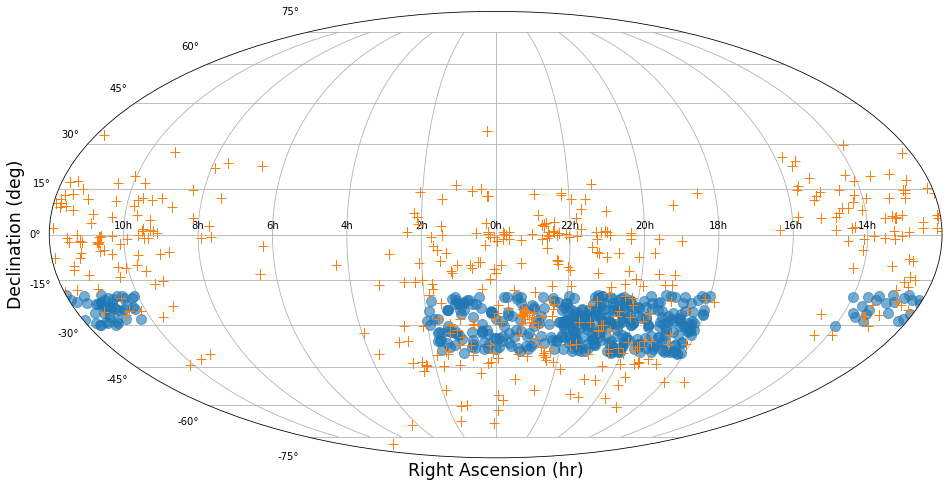

In [92]:
# Plot of full Ra-Dec of SPT and SQUAD
plt.figure(figsize=(16,9))
plt.subplot(111, projection="mollweide")
#plt.title("SPT + KQCG",fontsize='xx-large')
plt.ylabel("Declination (deg)",fontsize='xx-large')
plt.xlabel("Right Ascension (hr)",fontsize='xx-large')
plt.grid(True)

plt.margins(0.005)
plt.xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]), labels=['10h', '8h', '6h', '4h', '2h', '0h','22h', '20h', '18h', '16h', '14h'])

plt.plot(tar_coord.ra.wrap_at('180d').radian, tar_coord.dec.radian, 'o', markersize=10, alpha=0.6, label='Target')
plt.plot(squad_coord.ra.wrap_at('180d').radian, squad_coord.dec.radian, '+', markersize=10, alpha=1.0, label='SQUAD-QSO')
#plt.legend(fancybox=True, fontsize='x-large')

plt.show()

UVES - 300 - 1100 nm
COS FUV - 90 - 215 nm
COS NUV - 165 - 320 nm 

# KODIAQ + RedMapper SDSS DR8

In [ ]:
'''
# Takes > 1 hour. Not practical for large datasets. Explore TOPCAT
viztab="J/ApJS/224/1/cat_dr8" #redMaPPer SDSS DR8
redshift_str='zlambda'
namecol='Name'
target, full_target, search_r, tar_coord, tar_dist = tar_read(viztab, redshift_str, namecol)
#qso = kodiaq_query(target, search_r)
qso = milliquas_query(target, search_r)

nqso, full_qso = table_comb(qso,target,tar_coord, tar_dist,namecol,redshift_str)

pltname='kqcg+redmapper.png'
plot_combtab(nqso,pltname)

'''